## Data fields
- DBNOs - Number of enemy players knocked.
- assists - Number of enemy players this player damaged that were killed by teammates.
- boosts - Number of boost items used.
- damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
- headshotKills - Number of enemy players killed with headshots.
- heals - Number of healing items used.
- Id - Player’s Id
- killPlace - Ranking in match of number of enemy players killed.
- killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
- killStreaks - Max number of enemy players killed in a short amount of time.
- kills - Number of enemy players killed.
- longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
- matchDuration - Duration of match in seconds.
- matchId - ID to identify match. There are no matches that are in both the training and testing set.
- matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
- rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
- revives - Number of times this player revived teammates.
- rideDistance - Total distance traveled in vehicles measured in meters.
- roadKills - Number of kills while in a vehicle.
- swimDistance - Total distance traveled by swimming measured in meters.
- teamKills - Number of times this player killed a teammate.
- vehicleDestroys - Number of vehicles destroyed.
- walkDistance - Total distance traveled on foot measured in meters.
- weaponsAcquired - Number of weapons picked up.
- winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
- groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
- numGroups - Number of groups we have data for in the match.
- maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [8]:
# Center all plots by CSS
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [21]:
pd.set_option("display.max_columns",30)
data = pd.read_csv('data/train_V2.csv')

# Drop row with NaN 'winPlacePerc' value
data.drop(2744604, inplace=True)

# Creat a backup just in case
data_copy = data.copy()

In [149]:
data = data_copy.copy()

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4446965 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 1017.8+ MB


In [24]:
data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.00,0,0.00,0,0,244.80,1,1466,0.44
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.00,0,11.04,0,0,1434.00,5,0,0.64
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.00,0,0.00,0,0,161.80,2,0,0.78
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.00,0,0.00,0,0,202.70,3,0,0.17
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.00,0,0.00,0,0,49.75,2,0,0.19


In [150]:
# Delete rows with unusual match types
goodMatchTypes = ["squad-fpp","duo-fpp","squad","solo-fpp","duo","solo"]
data = data.query("matchType in @goodMatchTypes")
data['matchType'].value_counts()
data.reset_index()

# Create column is first person perspective
fppList = ["squad-fpp","duo-fpp","solo-fpp"]
data['isFPP'] = data['matchType'].apply(lambda x: x in fppList).astype(int)

# Create column that ignores the FPP sub-type
data["matchTypeIgnoreFPP"]= data["matchType"].str.replace('-fpp', "") 

# Drop useless columns
cols = [0,1,2]
data.drop(data.columns[cols],axis=1,inplace=True)

# Move columns around
data = data[['matchType','matchTypeIgnoreFPP', 'isFPP', 'winPoints',
       'winPlacePerc', 'assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill',
       'matchDuration', 'maxPlace', 'numGroups', 'rankPoints',
       'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired']]

In [151]:
sampleData = data.sample(100000)
sampleData = sampleData.reset_index()
sampleData.drop(sampleData.columns[0],axis=1,inplace=True)
sampleData.head()

,matchType,matchTypeIgnoreFPP,isFPP,winPoints,winPlacePerc,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired
0,squad,squad,0,0,0.27,0,0,161.30,0,0,6,26,0,1,1,85.56,1873,27,27,1500,0,0.00,0,0.00,0,0,1204.00,4
1,duo,duo,0,0,0.00,0,0,54.40,0,0,0,96,0,0,0,0.00,1368,49,49,1500,0,0.00,0,0.00,0,0,32.53,1
2,solo-fpp,solo,1,1461,0.96,0,4,399.50,0,0,3,12,1075,2,1,12.67,1925,98,94,-1,0,0.00,0,0.00,0,0,4182.00,5
3,squad-fpp,squad,1,1498,0.67,0,1,232.40,3,0,2,48,1300,0,0,0.00,1182,28,26,-1,2,0.00,0,0.00,0,0,911.70,8
4,duo-fpp,duo,1,0,0.85,0,2,150.70,0,0,2,53,0,0,0,0.00,1937,48,46,1513,0,0.00,0,0.00,0,0,3260.00,3


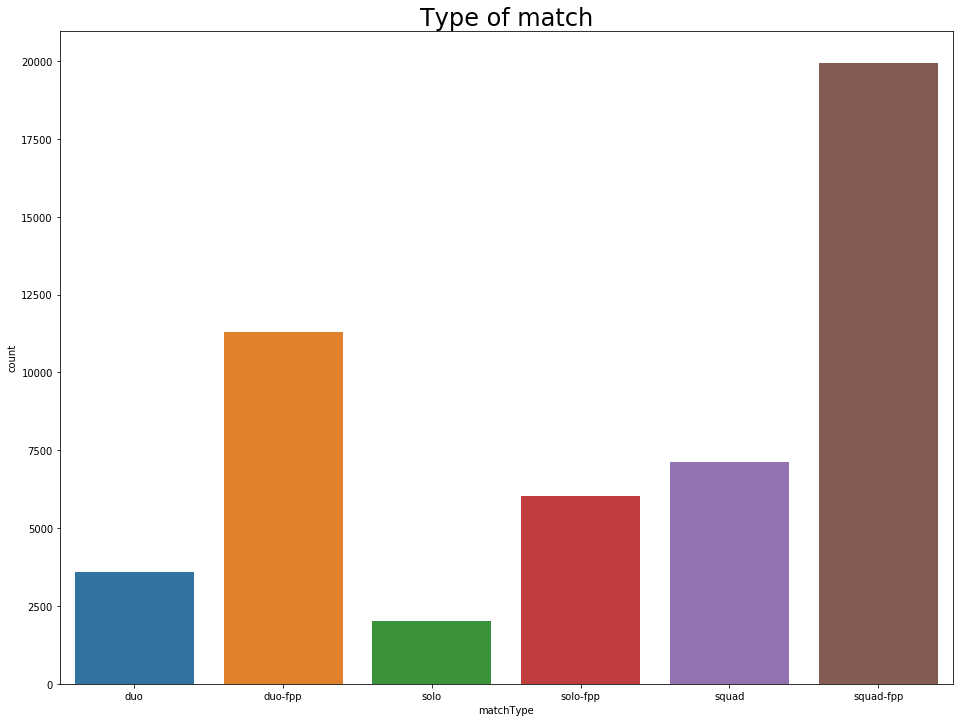

In [40]:
plt.figure(figsize=(16,12))
sns.countplot(sampleData['matchType'].astype('str').sort_values())
plt.title("Type of match",fontsize=24)
plt.show()

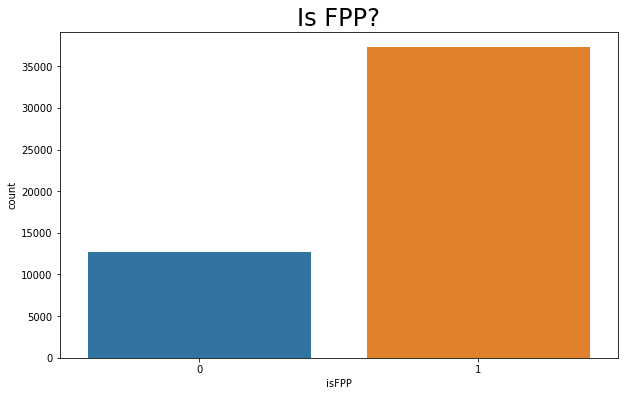

In [41]:
plt.figure(figsize=(10,6))
sns.countplot(sampleData['isFPP'].astype('str').sort_values())
plt.title("Is FPP?",fontsize=24)
plt.show()

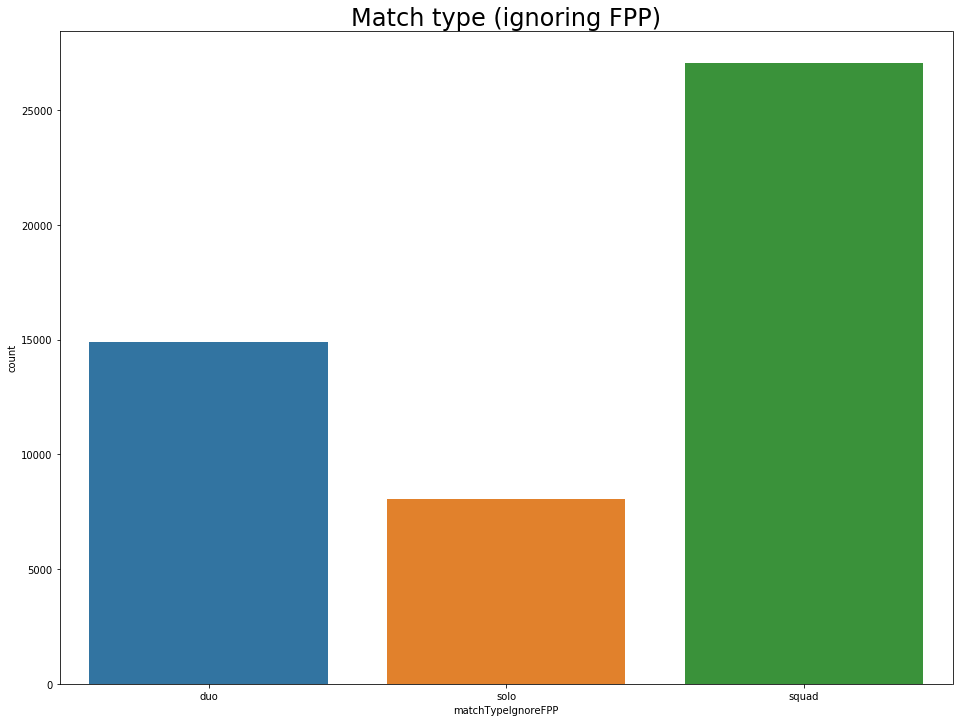

In [42]:
plt.figure(figsize=(16,12))
sns.countplot(sampleData['matchTypeIgnoreFPP'].astype('str').sort_values())
plt.title("Match type (ignoring FPP)",fontsize=24)
plt.show()

In [43]:
pd.set_option('display.float_format', lambda x: '%.2f' %x)
sampleData.describe()

,isFPP,winPoints,winPlacePerc,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired
count,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00
mean,0.75,607.55,0.47,0.23,1.12,129.40,0.65,0.22,1.39,47.74,506.32,0.91,0.54,22.84,1579.90,44.53,43.04,891.42,0.17,602.00,0.00,4.72,0.02,0.01,1157.88,3.65
std,0.44,740.16,0.31,0.57,1.74,165.41,1.12,0.58,2.72,27.49,628.16,1.49,0.70,50.56,254.34,23.69,23.16,736.95,0.48,1477.08,0.07,31.13,0.17,0.09,1185.05,2.33
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,840.00,4.00,1.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.20,0.00,0.00,0.00,0.00,0.00,0.00,24.00,0.00,0.00,0.00,0.00,1367.00,28.00,27.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,154.70,2.00
50%,1.00,0.00,0.46,0.00,0.00,83.85,0.00,0.00,0.00,48.00,0.00,0.00,0.00,0.00,1438.00,30.00,30.00,1443.00,0.00,0.00,0.00,0.00,0.00,0.00,691.65,3.00
75%,1.00,1495.00,0.74,0.00,2.00,186.00,1.00,0.00,2.00,71.00,1175.00,1.00,1.00,21.09,1849.00,49.00,47.00,1500.00,0.00,2.59,0.00,0.00,0.00,0.00,1985.00,5.00
max,1.00,1999.00,1.00,7.00,17.00,2262.00,17.00,11.00,44.00,100.00,2112.00,18.00,7.00,975.50,2237.00,100.00,100.00,3128.00,17.00,22220.00,6.00,952.30,4.00,3.00,10880.00,23.00


In [62]:
sampleData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 28 columns):
matchType             50000 non-null object
matchTypeIgnoreFPP    50000 non-null object
isFPP                 50000 non-null int32
winPoints             50000 non-null int64
winPlacePerc          50000 non-null float64
assists               50000 non-null int64
boosts                50000 non-null int64
damageDealt           50000 non-null float64
DBNOs                 50000 non-null int64
headshotKills         50000 non-null int64
heals                 50000 non-null int64
killPlace             50000 non-null int64
killPoints            50000 non-null int64
kills                 50000 non-null int64
killStreaks           50000 non-null int64
longestKill           50000 non-null float64
matchDuration         50000 non-null int64
maxPlace              50000 non-null int64
numGroups             50000 non-null int64
rankPoints            50000 non-null int64
revives               5

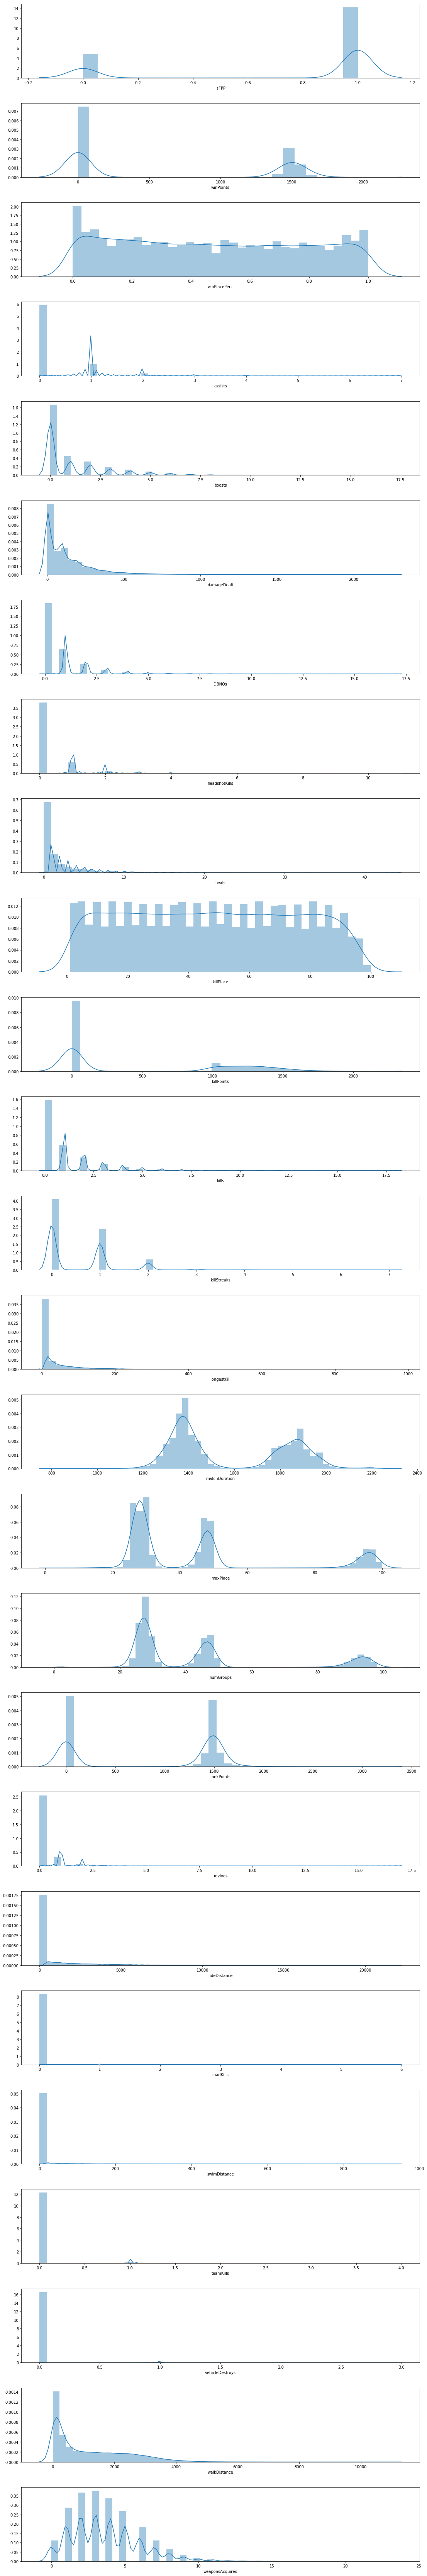

In [66]:
fig = plt.figure(figsize=(16,100))

for i, col in enumerate(sampleData.columns[2:]):
    ax = fig.add_subplot(28, 1, i + 1)
    sns.distplot(sampleData[col])

fig.tight_layout(pad=3)

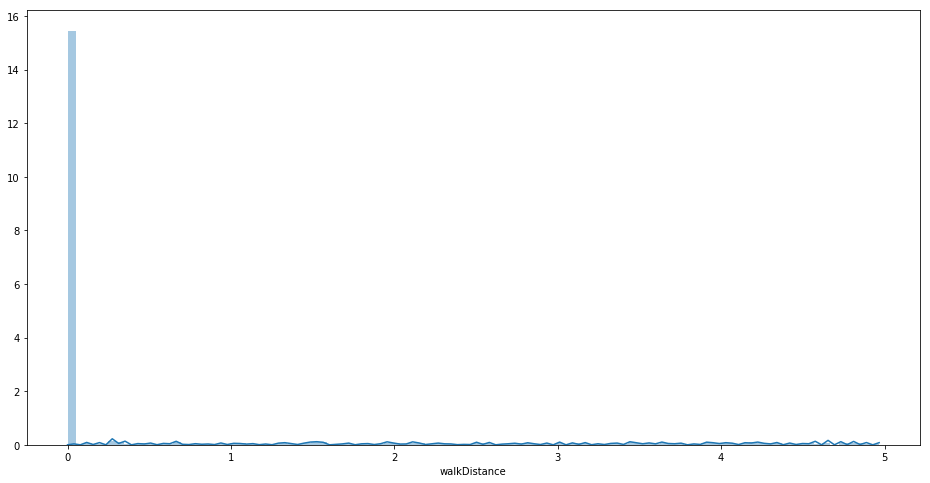

In [99]:
fig = plt.figure(figsize=(16,8))
sns.distplot(sampleData.query("walkDistance < 5")["walkDistance"], bins = 100)

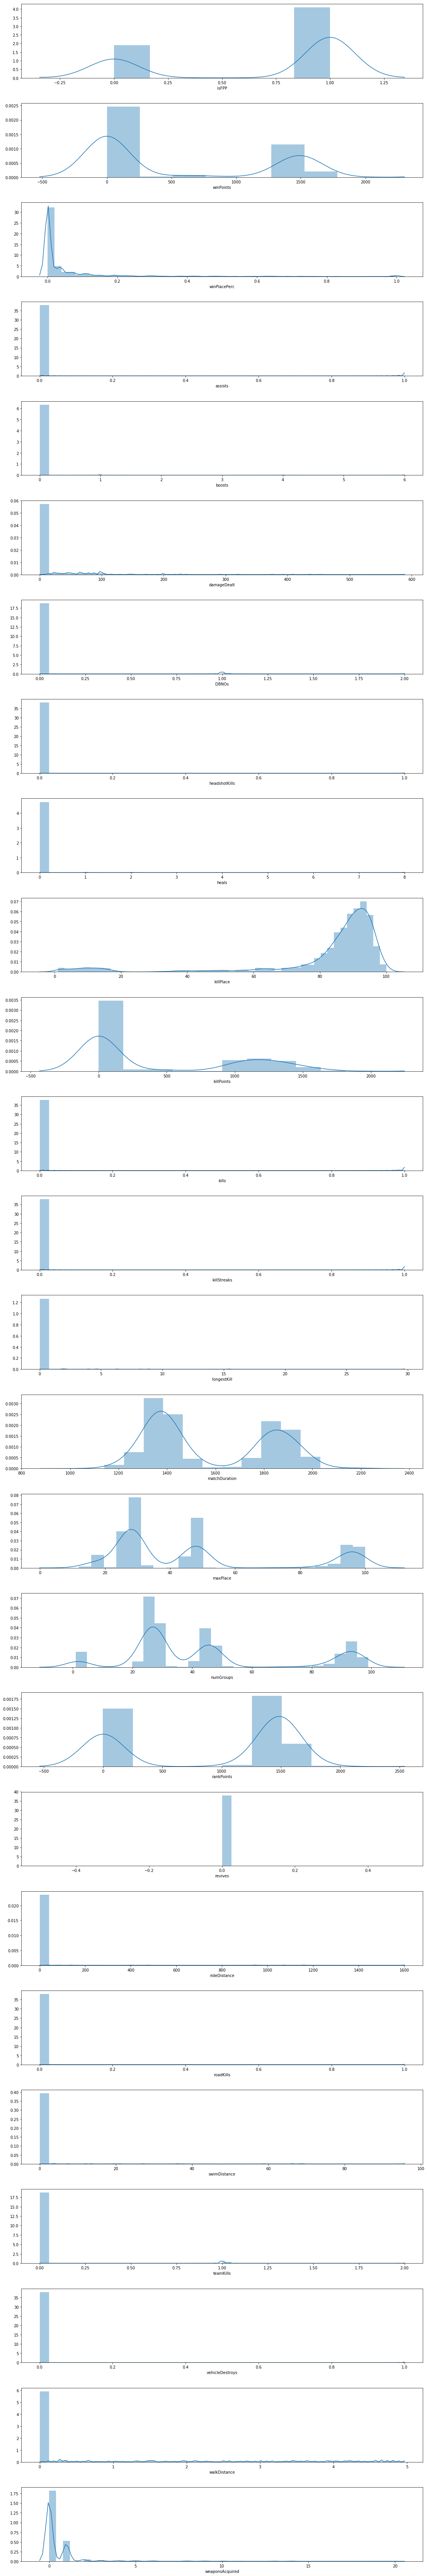

In [86]:
#Let's analize players that have moved less than 6 meters 

fig = plt.figure(figsize=(16,100))

cutSet = sampleData.query("walkDistance < 5")

for i, col in enumerate(cutSet.columns[2:]):
    ax = fig.add_subplot(28, 1, i + 1)
    sns.distplot(cutSet[col])

fig.tight_layout(pad=3)

In [152]:
# Let's remove afk players
len(sampleData.query("walkDistance < 5"))/len(sampleData)
sampleData = sampleData.query("walkDistance > 5")

G:\Aplikacje\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


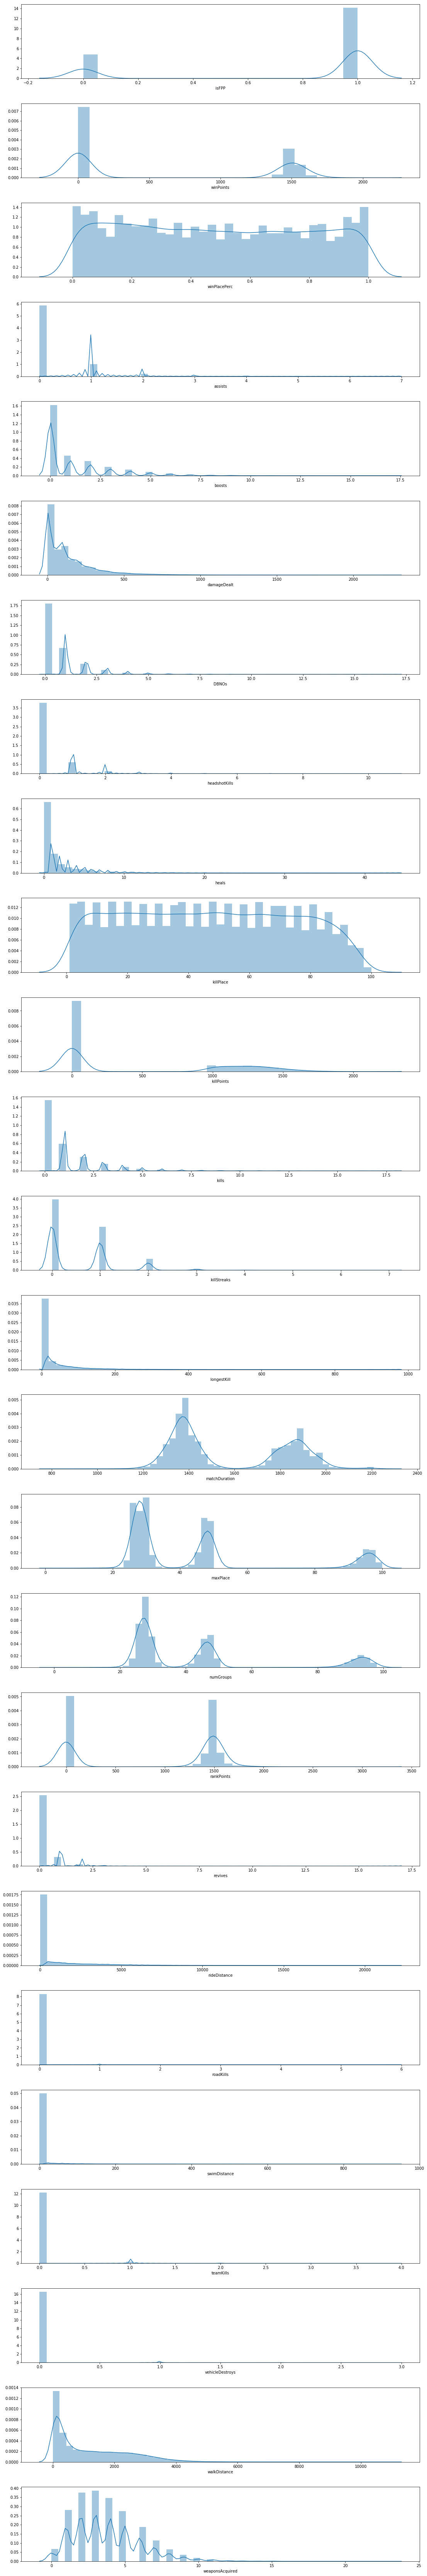

In [104]:
fig = plt.figure(figsize=(16,100))

for i, col in enumerate(sampleData.columns[2:]):
    ax = fig.add_subplot(28, 1, i + 1)
    sns.distplot(sampleData[col])

fig.tight_layout(pad=3)

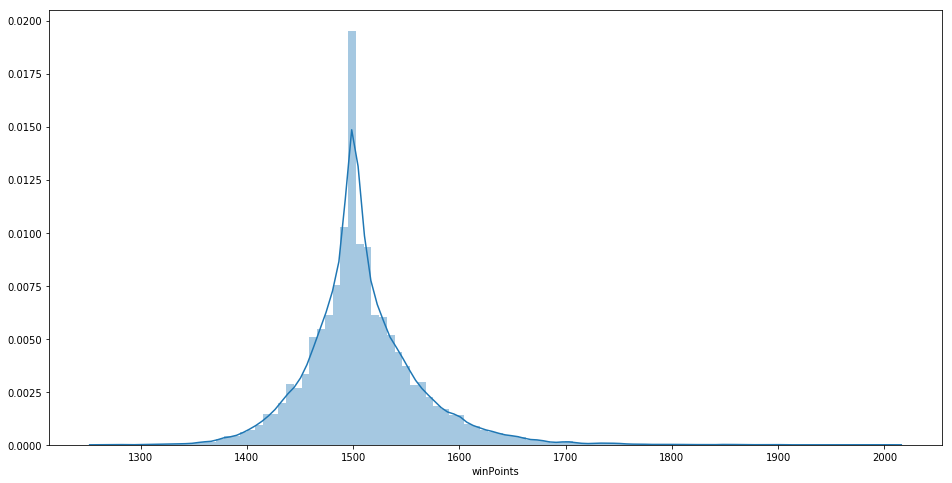

In [107]:
fig = plt.figure(figsize=(16,8))
sns.distplot(sampleData.query("winPoints > 5")["winPoints"], bins = 100)

In [153]:
sampleData['isNewbie'] = sampleData['winPoints'].apply(lambda x: x > 5).astype(int)

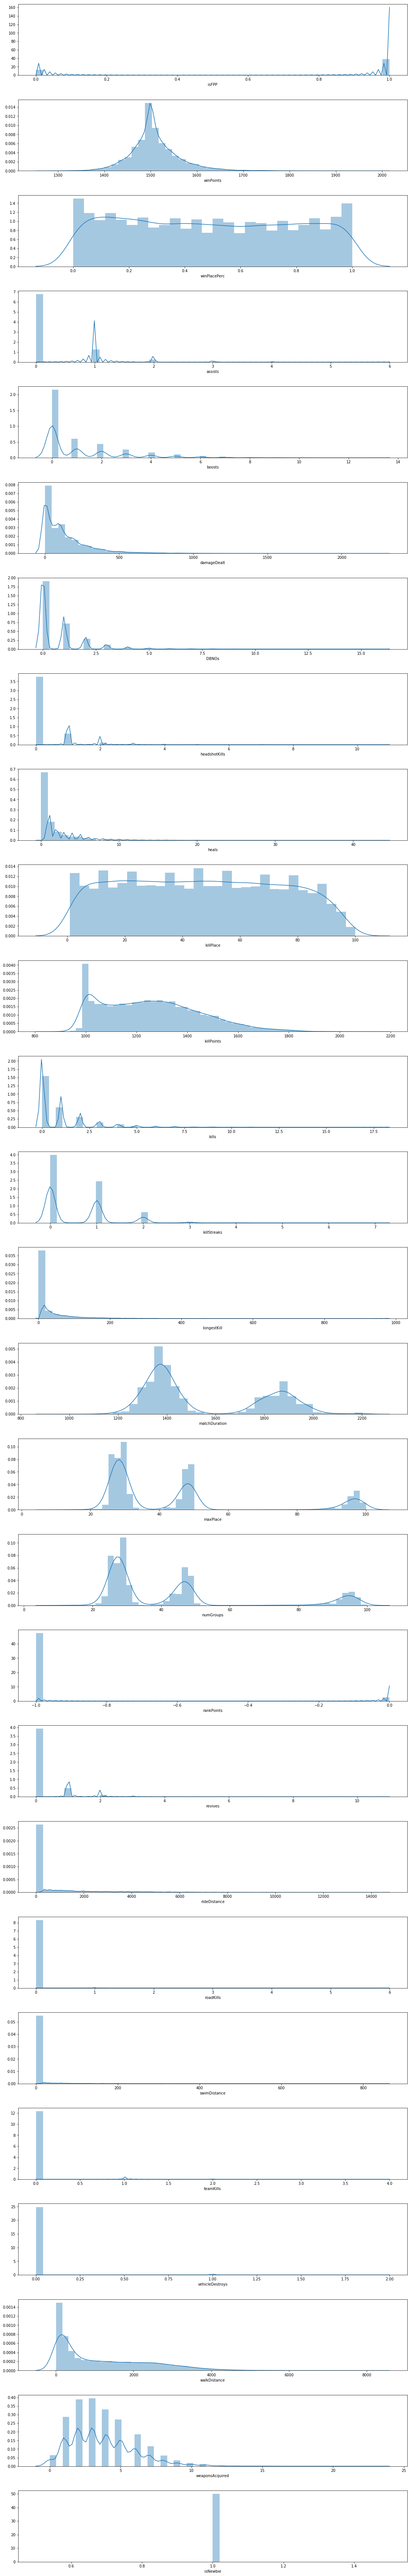

In [113]:
fig = plt.figure(figsize=(16,100))
sampleData2 = sampleData.query("winPoints > 5")
for i, col in enumerate(sampleData2.columns[2:]):
    ax = fig.add_subplot(28, 1, i + 1)
    sns.distplot(sampleData2[col])

fig.tight_layout(pad=3)

In [154]:
# Drop useless columns

# killPlace - place in a kill ranking
# longestKill - inconsistent
# maxPlace - Correlated with type of game
# numGroups -  Correlated with type of game
# rankPoints - inconsistent

columnsToDrop = ["killPlace", "longestKill", "maxPlace", "numGroups", "rankPoints"]
sampleData.drop(columns = columnsToDrop, inplace=True)

In [156]:
sampleData['rideDistance'] = sampleData['rideDistance'].apply(lambda x: x > 10).astype(int)
sampleData['swimDistance'] = sampleData['swimDistance'].apply(lambda x: x > 2).astype(int)

In [157]:
sampleData = sampleData.rename(index=str, columns={"rideDistance": "driver", "swimDistance": "swimmer"})

In [159]:
sampleData['driver'].value_counts()

0    72583
1    24531
Name: driver, dtype: int64

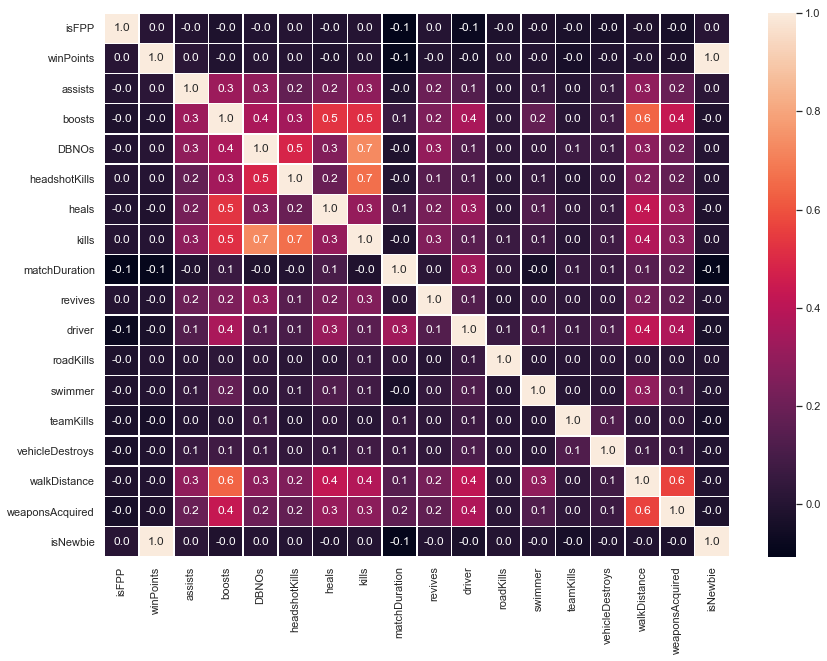

In [161]:
sampleData2 = sampleData.drop(columns = ['damageDealt', 'killStreaks', 'killPoints', 'winPlacePerc'])
f,ax = plt.subplots(figsize=(14, 10))
sns.heatmap(sampleData2.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

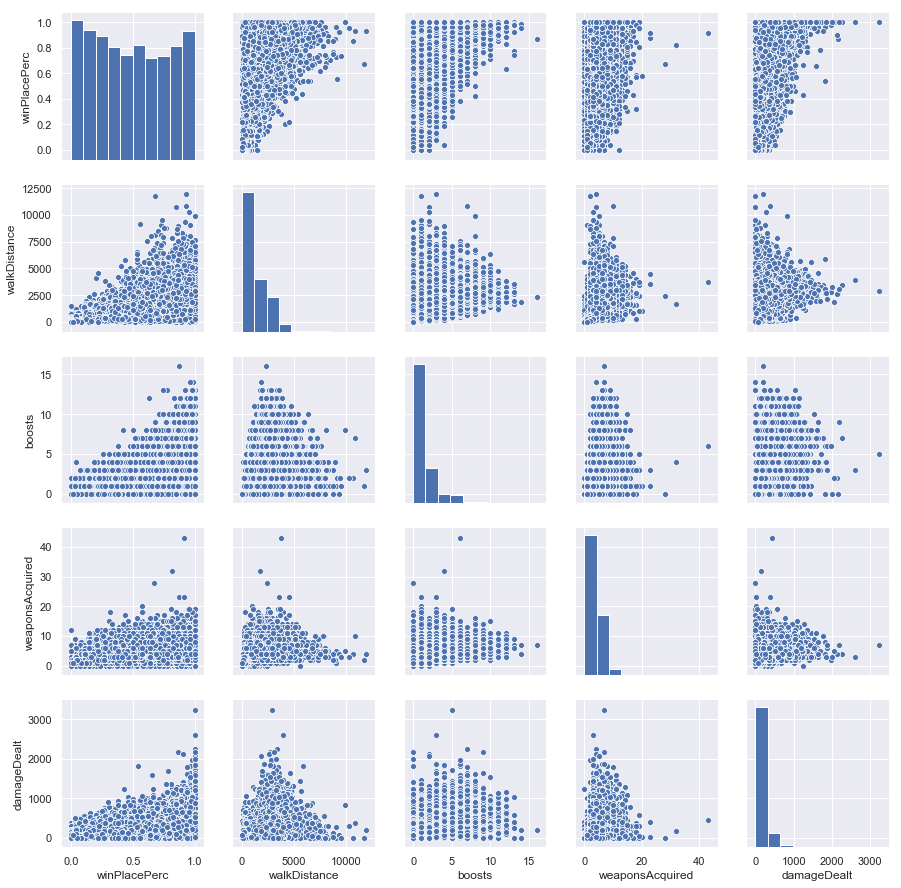

In [162]:
sns.set()
cols = ['winPlacePerc', 'walkDistance', 'boosts', 'weaponsAcquired', 'damageDealt']
sns.pairplot(sampleData[cols], height = 2.5)
plt.show()